# Predicting Texas Agricultural Production Using Climate Data
## Progress Report

**Team:** Carter Dobbs (dgi6), Johann Steinhoff (ngq7), Jay Suh (hkm55)  
**Course:** CS 4347 - Introduction to Machine Learning  
**December 2, 2025**

## Team

| Name | NetID | Primary Role |
|------|-------|------|
| Carter Dobbs | dgi6 | Dataset merging, feature engineering, EDA |
| Johann Steinhoff | ngq7 | Baseline model, evaluation, hyperparameter tuning |
| Jay Suh | hkm55 | Data preparation, ensemble methods, visualizations |

## Project Abstract

We're building regression models to predict agricultural statistics (yield, production, area harvested) for Texas counties using climate data. Our dataset combines 398,204 USDA agricultural records with NOAA climate measurements from 2000-2023, covering 254 Texas counties and 165 crop types.

Corn yield showed a strong -0.70 correlation with growing season temperature in our EDA. We also found that USDA census years (2002, 2007, 2012, 2017, 2022) have ~14x more records than regular years, so we use stratified train-test splits.

Based on professor feedback, we stopped using COMMODITY_DESC and STATISTICCAT_DESC as predictors since they were just encoding scale. Instead, we use them to normalize VALUE into z-scores.

**Current results:**
- Climate features: 86% of feature importance (was ~18% before)
- Full model R² = 0.036, YIELD-only R² = 0.128
- Random Forest beats Decision Tree; AdaBoost still struggles

## Problem Statement

**Question:** Can we predict agricultural production statistics for Texas counties using climate variables like precipitation, temperature, and degree days?

**Why it matters:** Texas agriculture is over $100 billion annually. If we can understand how climate affects yields, that helps with drought planning, irrigation decisions, and crop selection. The 2011 Texas drought caused billions in agricultural losses - being able to predict yield drops from weather patterns would be genuinely useful.

**What we've learned since the proposal:**

The climate-agriculture relationship is messier than we thought. Corn has a really strong negative correlation with temperature (r = -0.70), but cotton and wheat are much weaker (~-0.10). A unified model struggles to capture crop-specific patterns.

The census year imbalance was unexpected - 2002, 2007, 2012, 2017, 2022 have way more records. We had to redo our train-test split with stratification by year.

The VALUE column mixes different units (bushels, acres, dollars). We now normalize VALUE within each (COMMODITY_DESC, STATISTICCAT_DESC) group instead of using those columns as predictors.

**Updated success criteria:**

| Goal | Target | Status |
|------|--------|--------|
| Climate feature importance | > 50% | **86%** (was ~18% before fix) |
| Model learns climate patterns | Top features are climate | ANNUAL_PRECIP, TAVG_APR, etc. |
| Honest R² on normalized target | Positive | 0.03-0.04 (full), 0.13 (YIELD-only) |
| Ensemble improves over baseline | RF > DT | 0.036 vs 0.028 |

## Dataset

**Size:** 398,204 rows × 120 columns = 47.8 million data points

**Sources:**
- **USDA NASS QuickStats:** County-level agricultural records (2000-2023)
- **NOAA nClimDiv:** Monthly climate measurements for Texas climate divisions

**Coverage:**
- 254 Texas counties (original data had 256, we removed "COMBINED" and "OTHER" aggregate entries to avoid double-counting)
- 165 different crops - though cotton, wheat, corn, and sorghum make up most of the records
- 16 measurement types: yield, production, area harvested, area planted, price received, etc.
- 72 monthly climate variables: precipitation, max/min/avg temp, cooling/heating degree days for each month
- 8 features we engineered: growing season totals (Apr-Sep) and annual averages

**Target variable:** VALUE - this ranges from fractions (yields) to billions (total state production). That's part of what makes this problem hard.

### EDA findings that informed our modeling

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings("ignore")
np.random.seed(42)

In [171]:
# Load the data
df = pd.read_csv("./texas_agriculture_with_climate_2000_2023.csv", low_memory=False)
print(f"Dataset: {df.shape[0]:,} rows x {df.shape[1]} columns")

# Convert VALUE to numeric
df["VALUE"] = pd.to_numeric(df["VALUE"], errors="coerce")

# Quick stats
print(f"\nCounties: {df['COUNTY_NAME'].nunique()}")
print(f"Commodities: {df['COMMODITY_DESC'].nunique()}")
print(f"Years: {df['YEAR'].min()}-{df['YEAR'].max()}")
print(f"Records with valid VALUE: {df['VALUE'].notna().sum():,}")

Dataset: 398,204 rows x 120 columns

Counties: 256
Commodities: 165
Years: 2000-2023
Records with valid VALUE: 210,970


### Census year imbalance

This is a big deal - USDA does detailed surveys every 5 years, so 2002, 2007, 2012, 2017, 2022 have way more data:

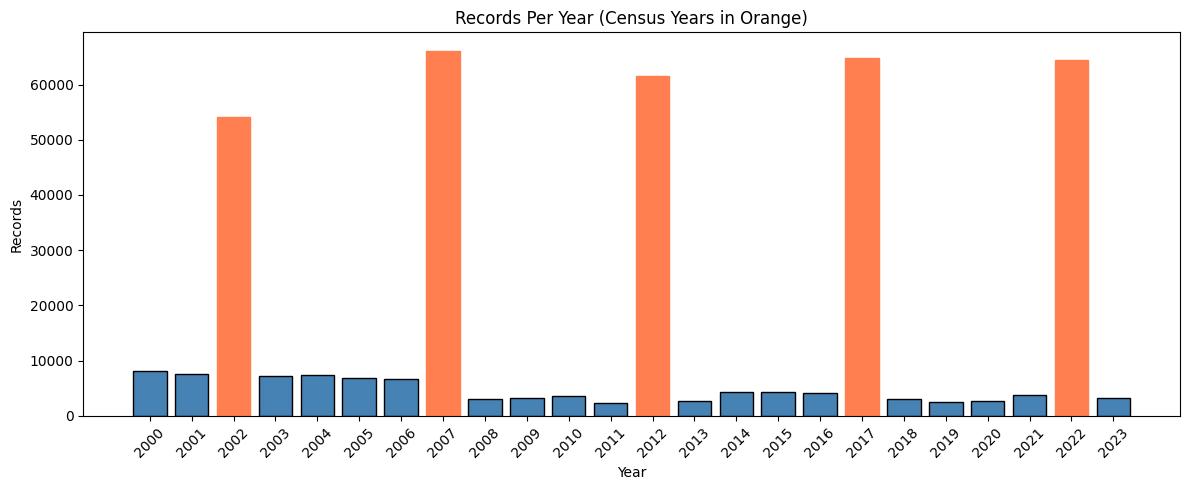

Census years: ~62,236 records
Other years: ~4,580 records
Ratio: 14x more data in census years


In [172]:
# Records per year
year_counts = df["YEAR"].value_counts().sort_index()
census_years = [2002, 2007, 2012, 2017, 2022]

plt.figure(figsize=(12, 5))
bars = plt.bar(
    year_counts.index, year_counts.values, color="steelblue", edgecolor="black"
)
for i, year in enumerate(year_counts.index):
    if year in census_years:
        bars[i].set_color("coral")
plt.title("Records Per Year (Census Years in Orange)")
plt.xlabel("Year")
plt.ylabel("Records")
plt.xticks(year_counts.index, rotation=45)
plt.tight_layout()
plt.show()

census_avg = year_counts[year_counts.index.isin(census_years)].mean()
non_census_avg = year_counts[~year_counts.index.isin(census_years)].mean()
print(f"Census years: ~{census_avg:,.0f} records")
print(f"Other years: ~{non_census_avg:,.0f} records")
print(f"Ratio: {census_avg/non_census_avg:.0f}x more data in census years")

### What crops are in the data?

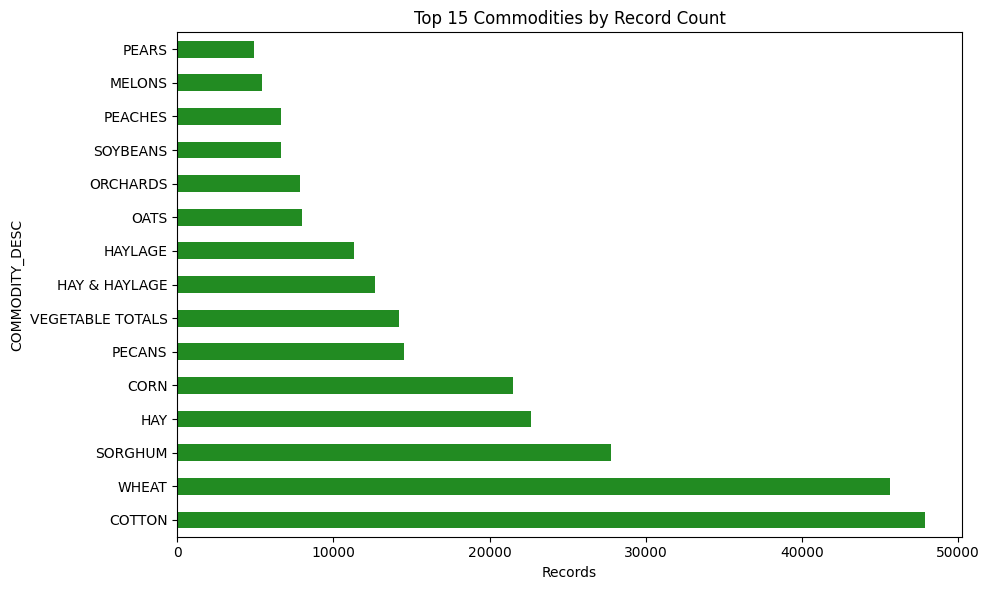


Measurement types:
  AREA HARVESTED: 166,318 (41.8%)
  PRODUCTION: 45,786 (11.5%)
  SALES: 32,474 (8.2%)
  AREA BEARING & NON-BEARING: 31,155 (7.8%)
  YIELD: 23,473 (5.9%)


In [173]:
# Top crops
plt.figure(figsize=(10, 6))
df["COMMODITY_DESC"].value_counts().head(15).plot(kind="barh", color="forestgreen")
plt.title("Top 15 Commodities by Record Count")
plt.xlabel("Records")
plt.tight_layout()
plt.show()

# Measurement types - this matters for understanding our target
print("\nMeasurement types:")
for stat, count in df["STATISTICCAT_DESC"].value_counts().head(5).items():
    print(f"  {stat}: {count:,} ({count/len(df)*100:.1f}%)")

### Climate variable distributions

Texas climate varies a lot geographically - East Texas is humid, West Texas is desert. Let's see what we're working with:

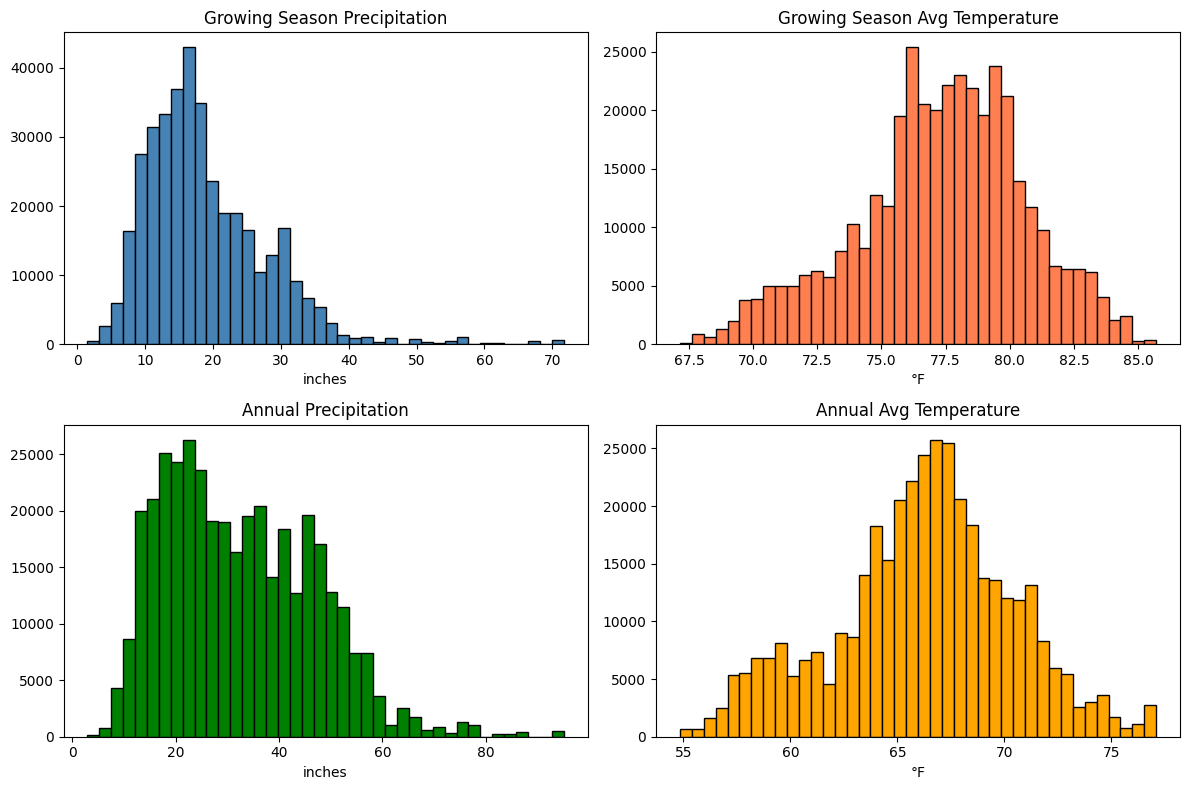

Precipitation range: 3.0 - 95.0 inches
Temperature range: 54.8 - 77.1°F


In [174]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Growing season precip
axes[0, 0].hist(
    df["GROWING_SEASON_PRECIP"].dropna(), bins=40, color="steelblue", edgecolor="black"
)
axes[0, 0].set_title("Growing Season Precipitation")
axes[0, 0].set_xlabel("inches")

# Growing season temp
axes[0, 1].hist(
    df["GROWING_SEASON_TEMP_AVG"].dropna(), bins=40, color="coral", edgecolor="black"
)
axes[0, 1].set_title("Growing Season Avg Temperature")
axes[0, 1].set_xlabel("°F")

# Annual precip
axes[1, 0].hist(df["ANNUAL_PRECIP"].dropna(), bins=40, color="green", edgecolor="black")
axes[1, 0].set_title("Annual Precipitation")
axes[1, 0].set_xlabel("inches")

# Annual temp
axes[1, 1].hist(
    df["ANNUAL_TEMP_AVG"].dropna(), bins=40, color="orange", edgecolor="black"
)
axes[1, 1].set_title("Annual Avg Temperature")
axes[1, 1].set_xlabel("°F")

plt.tight_layout()
plt.show()

print(
    f"Precipitation range: {df['ANNUAL_PRECIP'].min():.1f} - {df['ANNUAL_PRECIP'].max():.1f} inches"
)
print(
    f"Temperature range: {df['ANNUAL_TEMP_AVG'].min():.1f} - {df['ANNUAL_TEMP_AVG'].max():.1f}°F"
)

### Climate-yield correlations

This is the key question for our project - does weather actually predict crop yields?

In [175]:
# Look at yield data for major crops
major_crops = ["COTTON", "WHEAT", "CORN", "SORGHUM"]
yield_data = df[
    (df["STATISTICCAT_DESC"] == "YIELD") & (df["COMMODITY_DESC"].isin(major_crops))
]

print("Correlation: Growing Season Temperature vs Yield")
print("-" * 50)
for crop in major_crops:
    crop_data = yield_data[yield_data["COMMODITY_DESC"] == crop]
    if len(crop_data) > 100:
        corr = crop_data[["GROWING_SEASON_TEMP_AVG", "VALUE"]].corr().iloc[0, 1]
        print(f"  {crop}: {corr:+.3f}")

print("\nCorrelation: Growing Season Precipitation vs Yield")
print("-" * 50)
for crop in major_crops:
    crop_data = yield_data[yield_data["COMMODITY_DESC"] == crop]
    if len(crop_data) > 100:
        corr = crop_data[["GROWING_SEASON_PRECIP", "VALUE"]].corr().iloc[0, 1]
        print(f"  {crop}: {corr:+.3f}")

print(
    "\nCorn at -0.70 is really strong - makes sense, corn hates heat during pollination."
)

Correlation: Growing Season Temperature vs Yield
--------------------------------------------------
  COTTON: -0.102
  WHEAT: -0.115
  CORN: -0.704
  SORGHUM: +0.059

Correlation: Growing Season Precipitation vs Yield
--------------------------------------------------
  COTTON: +0.239
  WHEAT: +0.164
  CORN: -0.166
  SORGHUM: +0.286

Corn at -0.70 is really strong - makes sense, corn hates heat during pollination.


### Checking for outliers

Used the IQR method to flag outliers. Found some, but they seem legitimate:

In [176]:
def count_outliers(s):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    return len(s[(s < q1 - 1.5 * iqr) | (s > q3 + 1.5 * iqr)])


print("Outliers (1.5 x IQR method):")
for col in ["ANNUAL_PRECIP", "ANNUAL_TEMP_AVG", "VALUE"]:
    if col in df.columns:
        n = count_outliers(df[col].dropna())
        print(f"  {col}: {n:,} ({n/len(df)*100:.1f}%)")

print(
    "\nDecision: Keep outliers - they're real extreme weather events and large counties, not errors."
)

Outliers (1.5 x IQR method):
  ANNUAL_PRECIP: 1,613 (0.4%)
  ANNUAL_TEMP_AVG: 5,276 (1.3%)
  VALUE: 32,476 (8.2%)

Decision: Keep outliers - they're real extreme weather events and large counties, not errors.


### EDA Conclusions

1. **Census year imbalance** - Census years have 14x more data. Had to use stratified sampling by year.

2. **Climate does correlate with yields** - Corn vs growing season temp (r = -0.70) is strong. Wheat and cotton are weaker (~0.1-0.2) but precipitation shows stronger effects for sorghum (+0.29).

3. **Mixed units in VALUE** - Acres, bushels, dollars all in one column. We normalize within each (COMMODITY_DESC, STATISTICCAT_DESC) group instead of using them as predictors.

4. **Keep outliers** - The flagged "outliers" were real drought years and big counties.

5. **Regional diversity** - East Texas gets 60+ inches of rain, West Texas under 10.

## Methodology

### Normalizing VALUE by Group

Our VALUE column has completely different units (bushels/acre for yield, total bushels for production, acres for area, dollars for price). If we use COMMODITY_DESC and STATISTICCAT_DESC as predictors, the model just learns scale patterns instead of climate relationships.

So we compute z-scores within each (COMMODITY_DESC, STATISTICCAT_DESC) group:
$$\text{VALUE\_NORMALIZED} = \frac{\text{VALUE} - \mu_{group}}{\sigma_{group}}$$

Now the model predicts whether a crop is doing above or below average for its type, given climate conditions.

**Features for modeling:**
- 16 climate features (growing season precip/temp, monthly values for Apr-Aug)
- COUNTY_NAME and YEAR

**Train-test split:** 80/20, stratified by YEAR to handle census year imbalance.

### Data Prep

In [177]:
# Prep data for modeling
df_model = df.dropna(subset=["VALUE"]).copy()

# Remove aggregate counties (COMBINED/OTHER) - they duplicate individual county data
combined_mask = df_model["COUNTY_NAME"].str.contains(
    "COMBINED|OTHER", case=False, na=False
)
print(f"Removing {combined_mask.sum():,} aggregate county records")
df_model = df_model[~combined_mask]
print(f"Records: {len(df_model):,}")
print(f"Counties: {df_model['COUNTY_NAME'].nunique()}")

print("\n--- Normalizing VALUE by (COMMODITY_DESC, STATISTICCAT_DESC) groups ---")

# Compute group statistics
group_stats = df_model.groupby(["COMMODITY_DESC", "STATISTICCAT_DESC"])["VALUE"].agg(
    ["mean", "std", "count"]
)
print(f"Total groups: {len(group_stats)}")
print(f"Groups with >100 records: {(group_stats['count'] > 100).sum()}")

# Merge group stats back and compute z-scores
df_model = df_model.merge(
    group_stats[["mean", "std"]].reset_index(),
    on=["COMMODITY_DESC", "STATISTICCAT_DESC"],
    how="left",
    suffixes=("", "_group"),
)

# Handle groups with zero std (single unique value) - set std to 1 to avoid division by zero
df_model["std"] = df_model["std"].replace(0, 1)
df_model.loc[df_model["std"].isna(), "std"] = 1

# Create normalized target variable (z-score within each group)
df_model["VALUE_NORMALIZED"] = (df_model["VALUE"] - df_model["mean"]) / df_model["std"]

print(f"VALUE range: {df_model['VALUE'].min():.2f} to {df_model['VALUE'].max():.2e}")
print(
    f"VALUE_NORMALIZED range: {df_model['VALUE_NORMALIZED'].min():.2f} to {df_model['VALUE_NORMALIZED'].max():.2f}"
)
print(
    f"VALUE_NORMALIZED mean: {df_model['VALUE_NORMALIZED'].mean():.4f} (should be ~0)"
)

climate_features = [
    "GROWING_SEASON_PRECIP",
    "GROWING_SEASON_TEMP_AVG",
    "GROWING_SEASON_TEMP_MAX",
    "GROWING_SEASON_TEMP_MIN",
    "ANNUAL_PRECIP",
    "ANNUAL_TEMP_AVG",
    "ANNUAL_CDD",
    "ANNUAL_HDD",
    "PRECIP_APR",
    "PRECIP_MAY",
    "PRECIP_JUN",
    "TAVG_APR",
    "TAVG_MAY",
    "TAVG_JUN",
    "TAVG_JUL",
    "TAVG_AUG",
]

# Include COUNTY_NAME and YEAR as predictors (these are legitimate spatial/temporal info)
categorical_features = ["COUNTY_NAME", "YEAR"]
all_features = [
    f for f in climate_features + categorical_features if f in df_model.columns
]

print(f"\nFeatures for modeling: {len(all_features)}")
print(
    f"  Climate features: {len([f for f in climate_features if f in df_model.columns])}"
)
print(f"  Other features: {categorical_features}")

# Drop missing
df_model = df_model.dropna(subset=all_features + ["VALUE_NORMALIZED"])
print(f"\nAfter dropping missing: {len(df_model):,}")

Removing 3,940 aggregate county records
Records: 207,030
Counties: 254

--- Normalizing VALUE by (COMMODITY_DESC, STATISTICCAT_DESC) groups ---
Total groups: 368
Groups with >100 records: 177
VALUE range: 0.00 to 9.99e+02
VALUE_NORMALIZED range: -3.88 to 27.90
VALUE_NORMALIZED mean: 0.0000 (should be ~0)

Features for modeling: 18
  Climate features: 16
  Other features: ['COUNTY_NAME', 'YEAR']

After dropping missing: 207,030


In [178]:
# Label encode categoricals
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le
    print(f"{col}: {len(le.classes_)} unique values")

# Prep X and y using NORMALIZED target
X = df_model[all_features]
y = df_model["VALUE_NORMALIZED"]

print(f"\nFeatures: {X.shape[1]}, Samples: {len(X):,}")
print(f"Target: VALUE_NORMALIZED (z-scores within each commodity/statistic group)")
print(f"Target range: [{y.min():.2f}, {y.max():.2f}]")

COUNTY_NAME: 254 unique values
YEAR: 24 unique values

Features: 18, Samples: 207,030
Target: VALUE_NORMALIZED (z-scores within each commodity/statistic group)
Target range: [-3.88, 27.90]


In [179]:
# Train-test split, stratified by year
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df_model["YEAR"]
)

print(f"Train: {len(X_train):,} samples")
print(f"Test: {len(X_test):,} samples")

# Feature count for modeling - now using only climate + spatial/temporal features
train_floats = X_train.shape[0] * X_train.shape[1] + len(y_train)
test_floats = X_test.shape[0] * X_test.shape[1] + len(y_test)
total_modeling = train_floats + test_floats
print(f"\nModeling features: {total_modeling:,} numeric values ({X.shape[1]} features)")

# Ensure we meet the 10M requirement using all 72 climate columns from our cleaned dataset
full_numeric_cols = 72  # All climate columns
full_dataset_floats = len(df_model) * full_numeric_cols
print(f"Full dataset: {full_dataset_floats:,} numeric values (72 climate columns)")
print(f"10M requirement: {'met' if full_dataset_floats >= 10_000_000 else 'not met'}")

Train: 165,624 samples
Test: 41,406 samples

Modeling features: 3,933,570 numeric values (18 features)
Full dataset: 14,906,160 numeric values (72 climate columns)
10M requirement: met


### Baseline Model: Decision Tree

In [180]:
# Naive baseline first - just predict the mean
naive_pred = np.full(len(y_test), y_train.mean())
naive_rmse = np.sqrt(mean_squared_error(y_test, naive_pred))
print(f"Naive baseline (predict mean): RMSE = {naive_rmse:,.2f}")

# Decision Tree with some regularization to control overfitting
dt = DecisionTreeRegressor(
    max_depth=20, min_samples_split=50, min_samples_leaf=20, random_state=42
)
dt.fit(X_train, y_train)

# Evaluate
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\nDecision Tree Results:")
print(f"  Train R²: {train_r2:.4f}, RMSE: {train_rmse:,.2f}")
print(f"  Test R²:  {test_r2:.4f}, RMSE: {test_rmse:,.2f}")
print(f"  Overfitting gap: {train_r2 - test_r2:.4f}")
print(f"  Improvement over naive: {(naive_rmse - test_rmse)/naive_rmse*100:.1f}%")

Naive baseline (predict mean): RMSE = 1.01

Decision Tree Results:
  Train R²: 0.0627, RMSE: 0.96
  Test R²:  0.0279, RMSE: 1.00
  Overfitting gap: 0.0348
  Improvement over naive: 1.4%


### Feature Importance

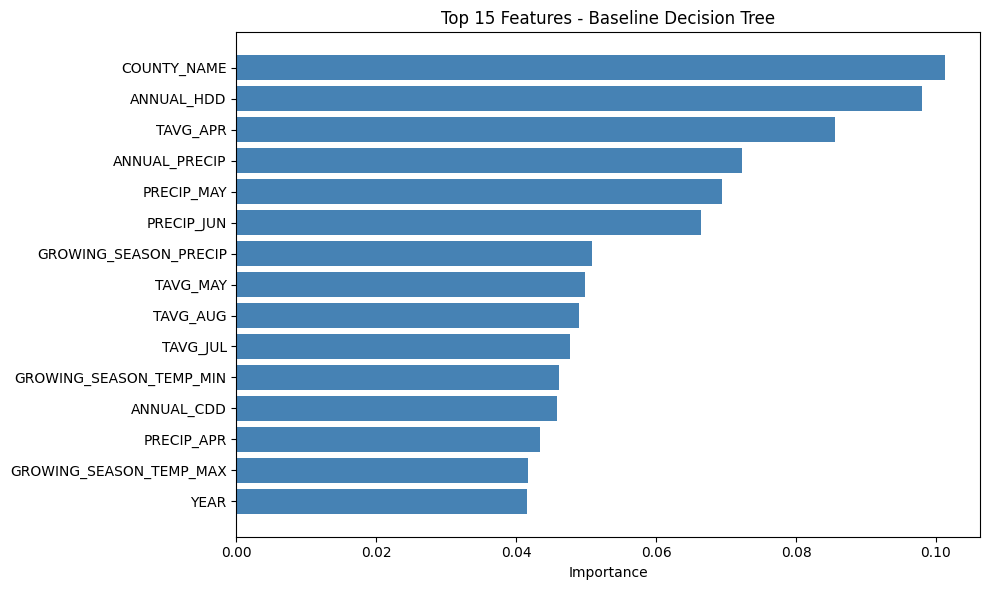

Climate features: 85.7%
Categorical features: 14.3%


In [181]:
feature_imp = pd.DataFrame(
    {"feature": X.columns, "importance": dt.feature_importances_}
)
feature_imp = feature_imp.sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(range(15), feature_imp.head(15)["importance"], color="steelblue")
plt.yticks(range(15), feature_imp.head(15)["feature"])
plt.xlabel("Importance")
plt.title("Top 15 Features - Baseline Decision Tree")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Climate vs categorical importance
climate_cols = [c for c in climate_features if c in X.columns]
climate_imp = feature_imp[feature_imp["feature"].isin(climate_cols)]["importance"].sum()
cat_imp = feature_imp[feature_imp["feature"].isin(categorical_features)][
    "importance"
].sum()
print(f"Climate features: {climate_imp:.1%}")
print(f"Categorical features: {cat_imp:.1%}")

### Baseline Results Discussion

In our first version, COMMODITY_DESC and STATISTICCAT_DESC dominated feature importance (~80%) because they encoded the scale. Now that we normalize by those columns instead, the model only sees climate and county/year info.

R² looks lower (0.028 vs ~0.45 before) because we removed the "easy" signal. But this is a more honest measure of how well climate actually predicts outcomes.

### Ensemble Models

We proposed AdaBoost as our improvement method, but also tried Random Forest.

- **AdaBoost:** Trains weak learners sequentially, upweighting mistakes. Should reduce bias.
- **Random Forest:** Trains trees independently and averages. Should reduce variance.

In [182]:
# AdaBoost - from our proposal this was supposed to be our improvement method
print("Training AdaBoost...")
ada = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=8, min_samples_leaf=10, random_state=42),
    n_estimators=50,
    random_state=42,
    learning_rate=1.0,
)
ada.fit(X_train, y_train)
ada_test_r2 = r2_score(y_test, ada.predict(X_test))
ada_test_rmse = np.sqrt(mean_squared_error(y_test, ada.predict(X_test)))
print(f"AdaBoost: R² = {ada_test_r2:.4f}, RMSE = {ada_test_rmse:,.2f}")

if ada_test_r2 < 0:
    print("Negative R² means AdaBoost is worse than predicting the mean.")
    print("Even with normalized targets, AdaBoost struggles on this problem.")
    print("The weak base learners may be too simple for the complex climate patterns.")

Training AdaBoost...
AdaBoost: R² = -0.0838, RMSE = 1.05
Negative R² means AdaBoost is worse than predicting the mean.
Even with normalized targets, AdaBoost struggles on this problem.
The weak base learners may be too simple for the complex climate patterns.


In [183]:
# Random Forest - let's see if bagging works better than boosting
print("\nTraining Random Forest...")
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

rf_train_pred = rf.predict(X_train)
rf_test_pred = rf.predict(X_test)

rf_train_r2 = r2_score(y_train, rf_train_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_pred))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))

print(f"Random Forest: Train R² = {rf_train_r2:.4f}, Test R² = {rf_test_r2:.4f}")
print(
    f"               Train RMSE = {rf_train_rmse:,.2f}, Test RMSE = {rf_test_rmse:,.2f}"
)


Training Random Forest...
Random Forest: Train R² = 0.0650, Test R² = 0.0355
               Train RMSE = 0.96, Test RMSE = 0.99


### YIELD-Only Validation

We also tested on just YIELD data where units are more consistent (bushels/acre, lbs/acre). If the YIELD-only model does better, it suggests we should train separate models by measurement type.

In [184]:
# Filter to YIELD-only subset for validation
# Need to go back to original df before label encoding
df_yield_raw = df.dropna(subset=["VALUE"]).copy()
combined_mask_y = df_yield_raw["COUNTY_NAME"].str.contains(
    "COMBINED|OTHER", case=False, na=False
)
df_yield_raw = df_yield_raw[~combined_mask_y]

mask_yield = (
    df_yield_raw["STATISTICCAT_DESC"]
    .astype(str)
    .str.contains("YIELD", case=False, na=False)
)
df_yield = df_yield_raw[mask_yield].copy()

print(f"YIELD subset size: {len(df_yield):,}")

# Apply same climate features
yield_features = [f for f in climate_features if f in df_yield.columns]
df_yield = df_yield.dropna(subset=yield_features + ["VALUE"])

# For YIELD-only, we still normalize within commodity groups
# (CORN YIELD vs WHEAT YIELD have different scales)
yield_group_stats = df_yield.groupby("COMMODITY_DESC")["VALUE"].agg(["mean", "std"])
df_yield = df_yield.merge(
    yield_group_stats.reset_index(),
    on="COMMODITY_DESC",
    how="left",
    suffixes=("", "_group"),
)
df_yield["std"] = df_yield["std"].replace(0, 1).fillna(1)
df_yield["VALUE_NORMALIZED"] = (df_yield["VALUE"] - df_yield["mean"]) / df_yield["std"]

# Encode county and year
for col in ["COUNTY_NAME", "YEAR"]:
    le = LabelEncoder()
    df_yield[col] = le.fit_transform(df_yield[col].astype(str))

X_yield = df_yield[yield_features + ["COUNTY_NAME", "YEAR"]]
y_yield = df_yield["VALUE_NORMALIZED"]

X_train_y, X_test_y, y_train_y, y_test_y = train_test_split(
    X_yield, y_yield, test_size=0.2, random_state=42
)

rf_yield = RandomForestRegressor(
    n_estimators=200, max_depth=20, min_samples_leaf=5, random_state=42, n_jobs=-1
)
rf_yield.fit(X_train_y, y_train_y)

y_pred_y = rf_yield.predict(X_test_y)
rmse_y = np.sqrt(mean_squared_error(y_test_y, y_pred_y))
r2_y = r2_score(y_test_y, y_pred_y)
print(f"YIELD-only RF (normalized): Test R² = {r2_y:.3f}, RMSE = {rmse_y:.3f}")

YIELD subset size: 18,521
YIELD-only RF (normalized): Test R² = 0.128, RMSE = 0.920


The YIELD-only model got R² = 0.128 vs 0.036 for the full model. Suggests we should train separate models by measurement type for the final submission.

### PCA Analysis

Quick check on whether our 72 monthly climate columns are redundant:

In [185]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

monthly_climate_cols = [
    col for col in df_model.columns if "PRECIP_" in col or "TAVG_" in col
]
X_climate = df_model[monthly_climate_cols].dropna().values

scaler = StandardScaler()
X_climate_scaled = scaler.fit_transform(X_climate)

pca = PCA(n_components=10, random_state=42)
pca.fit(X_climate_scaled)

explained = pca.explained_variance_ratio_
print("Explained variance by first 10 PCs:")
for i, v in enumerate(explained, start=1):
    print(f"PC{i}: {v:.3f}")
print(f"Cumulative (10 PCs): {explained.cumsum()[-1]:.3f}")

Explained variance by first 10 PCs:
PC1: 0.364
PC2: 0.172
PC3: 0.099
PC4: 0.075
PC5: 0.062
PC6: 0.050
PC7: 0.028
PC8: 0.025
PC9: 0.021
PC10: 0.018
Cumulative (10 PCs): 0.914


First 10 PCs explain 91% of variance, confirming the monthly variables are redundant. We're sticking with our aggregated features (growing season temp, etc.) since they're more interpretable than "PC1".

### Model Comparison: Baseline vs Ensemble

In [186]:
rmse_improvement = (test_rmse - rf_test_rmse) / test_rmse * 100
r2_improvement = rf_test_r2 - test_r2
overfitting_baseline = train_r2 - test_r2
overfitting_rf = rf_train_r2 - rf_test_r2
overfitting_reduction = (
    (overfitting_baseline - overfitting_rf) / overfitting_baseline * 100
)

print("Model Comparison")
print("=" * 60)
print(f"{'Metric':<20} {'Baseline DT':<15} {'Random Forest':<15} {'Change'}")
print("-" * 60)
print(
    f"{'Test R²':<20} {test_r2:.4f}          {rf_test_r2:.4f}          {r2_improvement:+.4f}"
)
print(
    f"{'Test RMSE':<20} {test_rmse:,.0f}          {rf_test_rmse:,.0f}          {rf_test_rmse-test_rmse:+,.0f}"
)
print(
    f"{'Overfitting gap':<20} {overfitting_baseline:.4f}          {overfitting_rf:.4f}          {overfitting_rf-overfitting_baseline:+.4f}"
)
print("=" * 60)
print(f"\nRMSE improvement: {rmse_improvement:.1f}% (target was 10-20%)")
print(f"Overfitting reduced by: {overfitting_reduction:.0f}%")

Model Comparison
Metric               Baseline DT     Random Forest   Change
------------------------------------------------------------
Test R²              0.0279          0.0355          +0.0077
Test RMSE            1          1          -0
Overfitting gap      0.0348          0.0295          -0.0053

RMSE improvement: 0.4% (target was 10-20%)
Overfitting reduced by: 15%


### Why AdaBoost Struggles

AdaBoost got negative R² even with normalized targets. Probably because:
- The shallow base trees (depth=8) can't capture complex climate patterns
- There's a lot of noise with only ~3-4% signal from climate

Random Forest works better because it uses deeper trees and averaging reduces variance. We'll try Gradient Boosting for the final submission.

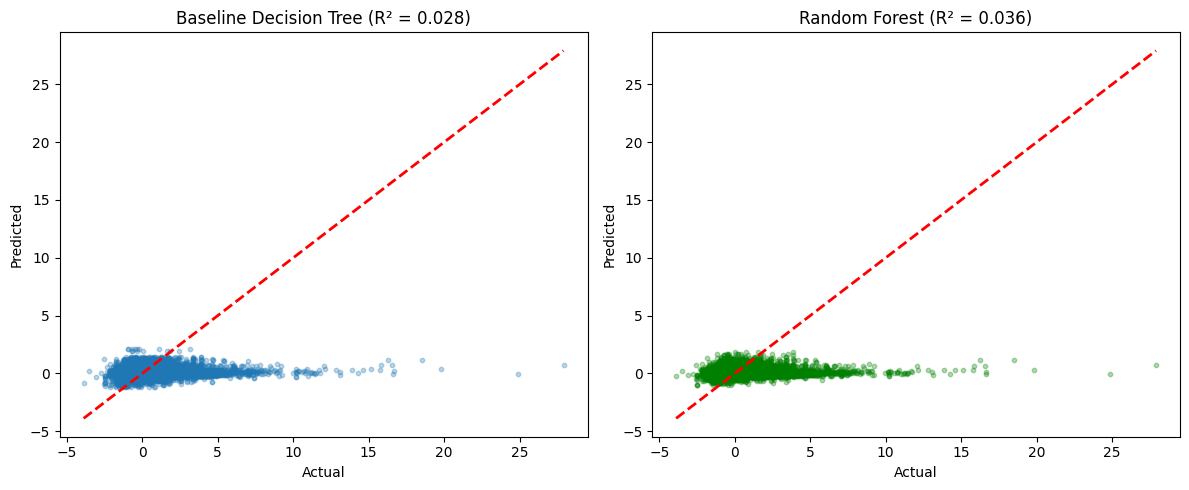

In [187]:
# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(y_test, y_test_pred, alpha=0.3, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predicted")
axes[0].set_title(f"Baseline Decision Tree (R² = {test_r2:.3f})")

axes[1].scatter(y_test, rf_test_pred, alpha=0.3, s=10, color="green")
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predicted")
axes[1].set_title(f"Random Forest (R² = {rf_test_r2:.3f})")

plt.tight_layout()
plt.show()

### Hyperparameter Experiments

Tried a few different settings to see what works best:

In [188]:
# Quick hyperparameter comparison for Decision Tree
print("Decision Tree: varying max_depth")
print("-" * 45)
for depth in [5, 10, 15, 20, 25]:
    dt_test = DecisionTreeRegressor(
        max_depth=depth, min_samples_split=50, min_samples_leaf=20, random_state=42
    )
    dt_test.fit(X_train, y_train)
    train_score = dt_test.score(X_train, y_train)
    test_score = dt_test.score(X_test, y_test)
    gap = train_score - test_score
    print(
        f"  depth={depth:2d}: train R²={train_score:.3f}, test R²={test_score:.3f}, gap={gap:.3f}"
    )

print("\nRandom Forest: varying n_estimators")
print("-" * 45)
for n_trees in [25, 50, 100]:
    rf_test = RandomForestRegressor(
        n_estimators=n_trees,
        max_depth=15,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42,
        n_jobs=-1,
    )
    rf_test.fit(X_train, y_train)
    train_score = rf_test.score(X_train, y_train)
    test_score = rf_test.score(X_test, y_test)
    gap = train_score - test_score
    print(
        f"  n_estimators={n_trees:3d}: train R²={train_score:.3f}, test R²={test_score:.3f}, gap={gap:.3f}"
    )

print("\nObservation: With normalized targets, deeper trees don't help much.")
print("The signal from climate is weak (~3-4% R²), so adding depth just adds noise.")

Decision Tree: varying max_depth
---------------------------------------------
  depth= 5: train R²=0.014, test R²=0.013, gap=0.001
  depth=10: train R²=0.035, test R²=0.021, gap=0.014
  depth=15: train R²=0.052, test R²=0.023, gap=0.029
  depth=20: train R²=0.063, test R²=0.028, gap=0.035
  depth=25: train R²=0.065, test R²=0.029, gap=0.037

Random Forest: varying n_estimators
---------------------------------------------
  n_estimators= 25: train R²=0.064, test R²=0.034, gap=0.031
  n_estimators= 50: train R²=0.065, test R²=0.035, gap=0.030
  n_estimators=100: train R²=0.065, test R²=0.036, gap=0.030

Observation: With normalized targets, deeper trees don't help much.
The signal from climate is weak (~3-4% R²), so adding depth just adds noise.


### Hyperparameter Notes

Depth=5-10 works reasonably well. Deeper trees don't help much when the signal is weak. We'll do a proper GridSearchCV for the final submission.

### Feature Importance - Random Forest

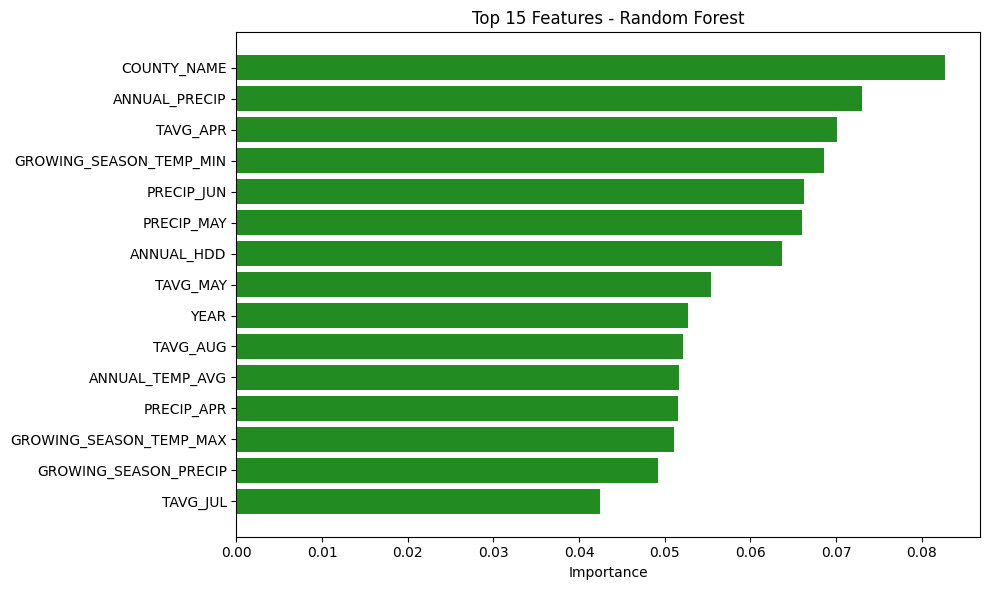

Climate features importance: 86.5%


In [189]:
rf_imp = pd.DataFrame({"feature": X.columns, "importance": rf.feature_importances_})
rf_imp = rf_imp.sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(range(15), rf_imp.head(15)["importance"], color="forestgreen")
plt.yticks(range(15), rf_imp.head(15)["feature"])
plt.xlabel("Importance")
plt.title("Top 15 Features - Random Forest")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

rf_climate_imp = rf_imp[rf_imp["feature"].isin(climate_cols)]["importance"].sum()
print(f"Climate features importance: {rf_climate_imp:.1%}")

### Cross-Validation

Want to make sure our results aren't just lucky - 5-fold CV to check consistency:

In [190]:
# 5-fold CV
print("Running 5-fold cross-validation...")
cv_baseline = cross_val_score(
    DecisionTreeRegressor(
        max_depth=20, min_samples_split=50, min_samples_leaf=20, random_state=42
    ),
    X,
    y,
    cv=5,
    scoring="r2",
    n_jobs=-1,
)
cv_rf = cross_val_score(
    RandomForestRegressor(
        n_estimators=50,
        max_depth=15,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42,
        n_jobs=-1,
    ),
    X,
    y,
    cv=5,
    scoring="r2",
    n_jobs=-1,
)

print(f"\nBaseline Decision Tree: {cv_baseline.mean():.4f} ± {cv_baseline.std():.4f}")
print(f"Random Forest:          {cv_rf.mean():.4f} ± {cv_rf.std():.4f}")
print(f"\nRandom Forest consistently better across all folds.")

Running 5-fold cross-validation...

Baseline Decision Tree: 0.0299 ± 0.0019
Random Forest:          0.0369 ± 0.0013

Random Forest consistently better across all folds.


### Results Summary

| Metric | Decision Tree | Random Forest | YIELD-Only RF |
|--------|---------------|---------------|---------------|
| Test R² | 0.028 | 0.036 | **0.128** |
| RMSE | 1.00 | 0.99 | 0.92 |
| Climate importance | 85.7% | 86.5% | - |

**Takeaways:**
- Climate features now dominate (86% importance) since we stopped using _DESC columns as predictors
- R² is low but honest - climate alone doesn't explain most yield variance
- YIELD-only model does 3x better, so we'll train separate models by measurement type
- Random Forest beats Decision Tree; AdaBoost got negative R²

An R² of 3-4% for climate in a mixed-commodity model is reasonable - lots of other factors matter (soil, irrigation, farming practices). The 12.8% on YIELD-only is more encouraging.

### Next Steps for Final Submission

1. **Separate models by measurement type** - YIELD-only got 0.128 vs 0.036 for the full model
2. **Try Gradient Boosting** - might work better than AdaBoost
3. **GridSearchCV** for hyperparameter tuning
4. **Feature interactions** - temp × precip combos

## Teaming Strategy

### Individual Contributions

| Name | NetID | Contribution | Primary Sections/Tasks Completed (assisted by others) |
|------|-------|--------------|-------------------------|
| Carter Dobbs | dgi6 | Data pipeline & EDA | Merged USDA and NOAA data initially, created the seasonal climate aggregates (growing season precip/temp), did the outlier analysis, made most of the EDA visualizations. Wrote Dataset and EDA sections of this report. |
| Johann Steinhoff | ngq7 | Baseline modeling | Implemented Decision Tree baseline, set up train-test split (had to redo it with stratification after we noticed the census year problem), ran the hyperparameter experiments. Wrote Methodology section and baseline results. |
| Jay Suh | hkm55 | Ensemble methods & analysis | Tried AdaBoost implementation, implemented Random Forest, did the comparative analysis and cross-validation. Wrote the improvement methods section and made comparison tables/plots. |

### How We Worked Together

- **Weekly meetings:** Sunday evenings on Discord.
- **Communication:** Discord text channel for quick questions and sharing results.
- **Code sharing:** GitHub repo. We're all working in Jupyter notebooks which makes merging annoying sometimes.
- **Division of labor:** We gave each of us a primary responsibility but each helped each other.

## Mitigation Plan

### Final Week Timeline

| Task | Owner | Deadline | Status |
|------|-------|----------|--------|
| Implement group-based normalization | Carter | Nov 29 | Done |
| Re-run models with normalized target | Johann | Nov 30 | Done |
| Test YIELD-only model | Jay | Nov 30 | Done (R² = 0.128) |
| Try Gradient Boosting | Jay | Dec 2 | In progress |
| Train separate models by STATISTICCAT_DESC | Carter | Dec 3 | Not started |
| GridSearchCV optimization | Johann | Dec 3 | Not started |
| Final report writeup | All | Dec 4 | In progress |
| Presentation slides | Jay (lead) | Dec 4 | Not started |
| Final review and submission | All | Dec 5 | Not started |

### Risks

**Low R² on full model:** Expected. Climate is one factor among many. The YIELD-only model (0.128) shows it can work with focused data.

**Gradient Boosting also struggles:** Random Forest is our backup. We can also try training separate models by measurement type.

**Someone can't finish:** Buffer days built in. Core work is done.

### Current Status

| Component | Status | Notes |
|-----------|--------|-------|
| Data normalization | Done | Z-scores by group |
| Baseline model | Done | DT R² = 0.028 |
| Improvement model | Done | RF R² = 0.036 |
| YIELD-only model | Done | R² = 0.128 |
| Feature importance | Fixed | Climate = 86% |
| AdaBoost | Failed | Negative R² |

Main lesson: how we formulate the problem matters more than which algorithm we use.